# Figure 2: Promoter Mutation Analysis

This notebook generates Figure 2 of the promoter bashing paper, showing:

1. **Binned effect statistics**: Mean and variance of mutational effects across promoter positions
2. **Reproducibility analysis**: Correlation between replicate experiments
3. **Nanoluciferase validation**: Comparison with independent reporter assays
4. **Volcano plots**: Statistical significance of mutational effects

## Data Sources
- Linear regression coefficients from: `03_mutant_effect_inference/02_linreg/`
- Nanoluciferase reporter data: `data/nanoluc/`
- Raw count data: `03_mutant_effect_inference/01_log_read_ratio/`

## Output
- All plots saved to `/data/davidding/dms/plots/fig2/`
- Both PNG (high-res) and SVG (vector) formats

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl
import importlib
import sys
from pathlib import Path
from os import listdir
from os.path import isfile

# Add src to path and import local modules
sys.path.append('../src/')
try:
    import config as cfg
    import plotting as pt
    import nucleotides as nt
except ImportError as e:
    print(f"Warning: Could not import local modules: {e}")
    print("Make sure you're running from the project root with src/ in your path")
    
# Setup plotting style
try:
    plt.style.use(str(cfg.STYLE_PATH))
except (AttributeError, FileNotFoundError):
    # Fallback to hardcoded path if config not available
    plt.style.use('/data/davidding/dms/dms_plants/src/paper_style1.mplstyle')
    print("Warning: Using fallback style path")

# Setup fonts
import matplotlib.font_manager as font_manager
try:
    font_path = str(cfg.FONT_PATH)
except AttributeError:
    font_path = '/data/davidding/dms/dms_plants/src/Arial.ttf'
    print("Warning: Using fallback font path")

if Path(font_path).exists():
    mpl.font_manager.fontManager.addfont(font_path)
    mpl.rcParams['font.family'] = 'Arial'
else:
    print(f"Warning: Font file not found at {font_path}")

# Set random seed for reproducibility
np.random.seed(42)

# Define paths - these should eventually come from config
dout = '/data/davidding/dms/plots/fig2/'
din_lr = '/data/davidding/dms/illumina_data/linreg_all/scaled_coeffs/'
din_raw = '/data/davidding/dms/illumina_data/data/clean/illumina/lrr_rcs_rescaled/'

# Gene color scheme
try:
    psbs_col = cfg.GENE_COLORS['psbs']
    raf1_col = cfg.GENE_COLORS['raf1']
    sbpase_col = cfg.GENE_COLORS['sbpase']
except (AttributeError, KeyError):
    # Fallback colors
    psbs_col = '#c0bfff'
    raf1_col = '#b7e6ff'
    sbpase_col = '#ff8eaa'

# Ensure output directory exists
Path(dout).mkdir(parents=True, exist_ok=True)

print("Setup complete!")
print(f"Output directory: {dout}")
print(f"Data directory (linreg): {din_lr}")
print(f"Gene colors: PsbS={psbs_col}, Raf1={raf1_col}, SBPase={sbpase_col}")

/data/davidding/miniconda3/env2/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# breaking the correlations down of psbs to smaller window, or deletion size

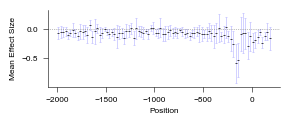

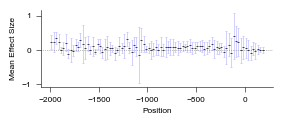

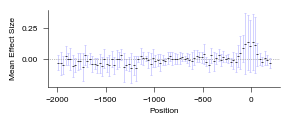

In [ ]:
def plot_binned_effect_stats(
        df, bin_size=50, 
        position_col='position', effect_col='effect', promoter_start=None, promoter_end=None, 
        figsize=(3,1),
        fs=5,
        fout=None
     ):
    """
    Plot mean, variance, and range statistics for binned effect data.
    
    df: pandas DataFrame with 'position' and 'effect' columns
    bin_size: number of base pairs per position bin
    position_col: column name for position
    effect_col: column name for effect size
    promoter_start: start position (optional, inferred from data if None)
    promoter_end: end position (optional, inferred from data if None)
    """
    if promoter_start is None:
        promoter_start = df[position_col].min()
    if promoter_end is None:
        promoter_end = df[position_col].max()

    # Bin the promoter positions
    bin_edges = np.arange(promoter_start, promoter_end + bin_size, bin_size)
    n_bins = len(bin_edges) - 1

    # Setup figure
    #fig, axes = plt.subplots(1, n_bins, figsize=(3,1), sharey=True)
    plt.figure(figsize=figsize)
    list_mid_points = []
    list_means = []
    list_vars = []
    for i in range(n_bins):
        bin_start = bin_edges[i]
        bin_end = bin_edges[i + 1]
        bin_df = df[(df[position_col] >= bin_start) & (df[position_col] < bin_end)]
        if len(bin_df) > 0:
            # Calculate statistics
            mid_point = (bin_start + bin_end) // 2
            mean_val = bin_df[effect_col].mean()
            var_val = bin_df[effect_col].var()
            list_mid_points.append(mid_point)
            list_means.append(mean_val)
            list_vars.append(var_val)

    plt.errorbar( list_mid_points, list_means, yerr=list_vars, fmt='_', markeredgewidth=0.5,
            color = 'black',ecolor='#c0bfff', linewidth=0.5, capsize=0.5, capthick=0.5, alpha=1, markersize=2)
    plt.axhline(0, color='gray', linestyle='dotted', lw=0.5)
    # Make axes and ticks thinner
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.4)  # Decrease axis linewidth
    plt.tick_params(width=0.4)  # Decrease tick width
    
    plt.xticks([-2000, -1500, -1000, -500, 0], fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('Position', fontsize=fs)
    plt.ylabel('Mean Effect Size', fontsize=fs)
    if fout != None:
        plt.savefig(fout, dpi=500, bbox_inches="tight")
        plt.savefig(fout+'.svg', format='svg', dpi=500, bbox_inches="tight")
    plt.show()

    
# Use the new function
for s in ['3C_sorghum','3B_sorghum', '3A_sorghum']:

    df_lr = pd.read_csv(din_lr + s + '_mean_lrr_lr.csv')

    df_lr['pos'] = df_lr.mut.apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)

    df_lr_plots = df_lr.loc[(df_lr.pos > -2001) & (df_lr.pos < 200)]
    plot_binned_effect_stats(df_lr_plots, 
                            bin_size=25, position_col='pos', 
                            effect_col='beta', figsize=(3,1), fs=6,
                            fout = dout + f'{s}_stats_beta_mean_lrr.png')

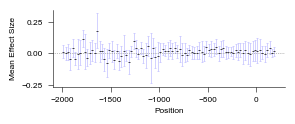

,Unnamed: 0,mut,beta_loge,pval,sig,n,mut_in_prom_utr,mean_lrr_observed_reads_loge,is_top_p,beta_log2,mean_lrr_observed_reads_log2,beta,mean_lrr_observed_reads
0,0,I-1101AATCGAGCAGCTGGCTTGTGGAGACCAGACAAAAAAGGAA...,1.311725,6.974878e-05,False,1,True,1.248926,True,1.892419,1.801820,1.890939,1.427119
1,1,I-2680T,1.178121,5.300297e-03,False,1,False,0.333872,False,1.699669,0.481675,1.698189,0.106974
2,2,I-1101AATCGAGCAGCTGGCTTGTGGGGACCAGACAAAAAAGGAA...,1.153317,4.094148e-07,True,1,True,1.169508,True,1.663884,1.687243,1.662404,1.312542
3,3,I-752CAATCGAGCAGCTGGCTTGTGGGGACCAGACAAAAAAGGAA...,1.126626,9.621316e-07,True,1,True,1.158755,True,1.625378,1.671730,1.623898,1.297029
4,4,C-603_________________________________________...,1.027040,1.047278e-02,False,1,True,0.424603,False,1.481706,0.612573,1.480226,0.237872
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14757,14757,T-503_________________________________________...,-1.205195,1.100173e-03,False,2,True,-0.141124,False,-1.738729,-0.203599,-1.740209,-0.578300
14758,14758,I-621TGTGTTTTAAAGTTTTGGCATAAGTTGTAAGTTATATGGTA...,-1.223200,2.200192e-07,True,1,True,-1.103562,False,-1.764705,-1.592103,-1.766185,-1.966804
14759,14759,T303C,-1.287374,3.350483e-08,True,1,False,-1.306295,False,-1.857289,-1.884585,-1.858769,-2.259285
14760,14760,I-91AGATGCTGACGTGGC,-1.289127,1.482328e-08,True,1,True,-1.275566,False,-1.859817,-1.840253,-1.861297,-2.214954


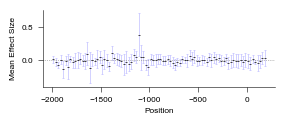

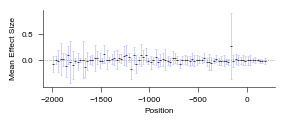

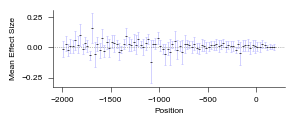

In [ ]:
# for the supplement
for s in ['2A_rice', '2B_sorghum', '2C_rice', '2C_sorghum']:
    df_lr = pd.read_csv(din_lr + s + '_mean_lrr_lr.csv')

    df_lr['pos'] = df_lr.mut.apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)

    df_lr_plots = df_lr.loc[(df_lr.pos > -2001) & (df_lr.pos < 200)]
    plot_binned_effect_stats(df_lr_plots, 
                            bin_size=25, position_col='pos', 
                            effect_col='beta', figsize=(3,1), fs=6,
                            fout = dout + f'{s}_stats_beta_mean_lrr.png')




# reproducibility of linear regression weights 

 beta old linreg


/data/davidding/dms/dms_plants/figures/../src/plotting.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1)  # Decrease padding around the entire figure


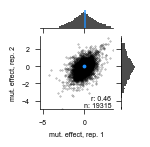

>-400 region


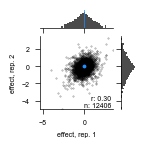

-400 to 168 region


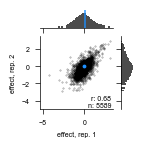

deletions
-400 to 168 region


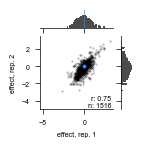

insertions
-400 to 168 region


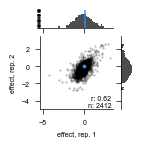

 beta old linreg


/data/davidding/dms/dms_plants/figures/../src/plotting.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1)  # Decrease padding around the entire figure


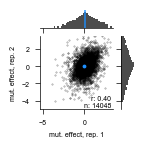

>-400 region


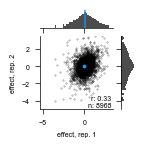

-400 to 70 region


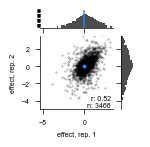

deletions
-400 to 70 region


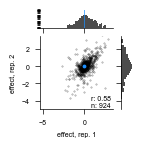

insertions
-400 to 70 region


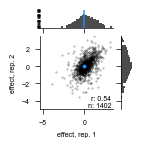

 beta old linreg


/data/davidding/dms/dms_plants/figures/../src/plotting.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1)  # Decrease padding around the entire figure


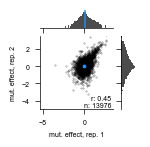

>-400 region


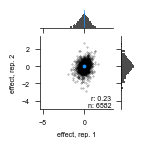

-400 to 256 region


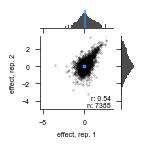

deletions
-400 to 256 region


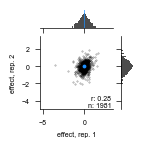

insertions
-400 to 256 region


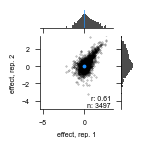

In [7]:
# raw reproducibility
importlib.reload(pt)
def plot_scatter_rep12_linreg(
        df_merge, start_region, end_region, s, dout,
        figsize=(1.3,1.3),
        align_text_bottom_right=True, 
        xlim = None, 
        ylim = None):
    
    # for all
    pt.scatter_with_marginals(
        df_merge['beta_r1'],
        df_merge['beta_r2'],
        x1= df_merge.loc[df_merge.mut == 'wt']["beta_r1"].values,
        y1 = df_merge.loc[df_merge.mut == 'wt']["beta_r2"].values,
        title=f" beta old linreg", 
        fig_size=figsize, 
        xlabel="mut. effect, rep. 1",
        ylabel="mut. effect, rep. 2",
        #save_path= dout +f'{s}_scatter_rep12_linreg.png',
        align_text_bottom_right=align_text_bottom_right, 
        save_path = dout + f'{s}_scatter_rep12_linreg.png', 
        fontsize=5,
        xlim = xlim,
        ylim = ylim
        )
    
    # outside core
    df_plot_outside = df_merge.loc[ (df_merge.pos < start_region)]
    pt.scatter_with_marginals(
        df_plot_outside['beta_r1'],
        df_plot_outside['beta_r2'],
        x1= df_merge.loc[df_merge.mut == 'wt']["beta_r1"].values,
        y1 = df_merge.loc[df_merge.mut == 'wt']["beta_r2"].values,
        title=f">{start_region} region", 
        fig_size=figsize, 
        xlabel="effect, rep. 1",
        ylabel="effect, rep. 2",
        #save_path= dout +f'{s}_scatter_rep12_linreg.png',
        align_text_bottom_right=align_text_bottom_right, 
        save_path = dout + f'{s}_scatter_rep12_linreg_before_{start_region}.png',
        fontsize=5,
        xlim = xlim,
        ylim = ylim
        )

    # just for small region
    # print all small regions ones
    df_plot_small = df_merge.loc[(df_merge.pos > start_region) & (df_merge.pos < end_region)]
    pt.scatter_with_marginals(
        df_plot_small['beta_r1'],
        df_plot_small['beta_r2'],
        x1= df_merge.loc[df_merge.mut == 'wt']["beta_r1"].values,
        y1 = df_merge.loc[df_merge.mut == 'wt']["beta_r2"].values,
        title=f"{start_region} to {end_region} region", 
        fig_size=figsize, 
        xlabel="effect, rep. 1",
        ylabel="effect, rep. 2",
        #save_path= dout +f'{s}_scatter_rep12_linreg.png',
        align_text_bottom_right=align_text_bottom_right, 
        save_path = dout + f'{s}_scatter_rep12_linreg_{start_region}_{end_region}.png',
        fontsize=5,
        xlim = xlim,
        ylim = ylim
        )
    print('deletions')
    df_plot = df_plot_small.loc[df_plot_small.mut.str.contains('_')]
    pt.scatter_with_marginals(
        df_plot['beta_r1'],
        df_plot['beta_r2'],
        x1= df_merge.loc[df_merge.mut == 'wt']["beta_r1"].values,
        y1 = df_merge.loc[df_merge.mut == 'wt']["beta_r2"].values,
        title=f"{start_region} to {end_region} region", 
        fig_size=figsize, 
        xlabel="effect, rep. 1",
        ylabel="effect, rep. 2",
        #save_path= dout +f'{s}_scatter_rep12_linreg.png',
        align_text_bottom_right=align_text_bottom_right, 
        save_path = dout + f'{s}_scatter_rep12_linreg_{start_region}_{end_region}_dels.png',
        fontsize=5,
        xlim = xlim,
        ylim = ylim
        )
    print('insertions')
    df_plot = df_plot_small.loc[df_plot_small.mut.str.startswith('I')]
    pt.scatter_with_marginals(
        df_plot['beta_r1'],
        df_plot['beta_r2'],
        x1= df_merge.loc[df_merge.mut == 'wt']["beta_r1"].values,
        y1 = df_merge.loc[df_merge.mut == 'wt']["beta_r2"].values,
        title=f"{start_region} to {end_region} region", 
        fig_size=figsize, 
        xlabel="effect, rep. 1",
        ylabel="effect, rep. 2",
        #save_path= dout +f'{s}_scatter_rep12_linreg.png',
        align_text_bottom_right=align_text_bottom_right, 
        save_path = dout + f'{s}_scatter_rep12_linreg_{start_region}_{end_region}_ins.png',
        fontsize=5,
        xlim = xlim,
        ylim = ylim
        )


s='3C_sorghum'
start_region = -400
end_region = 168

# for linear regression weights
df_lr1 = pd.read_csv(din_lr + f'{s}_lrr_rep1_lr.csv')
df_lr2 = pd.read_csv(din_lr + f'{s}_lrr_rep2_lr.csv')
df_merge = df_lr1.merge(df_lr2, on = 'mut', suffixes=('_r1','_r2'))
df_merge['pos'] = df_merge.mut.apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)

plot_scatter_rep12_linreg(
        df_merge, start_region, end_region, s, dout,
        align_text_bottom_right=True, xlim = [-5.4, 3.5], ylim = [-5, 3.5])

s='3B_sorghum'
start_region = -400
end_region = 70

# for linear regression weights
df_lr1 = pd.read_csv(din_lr + f'{s}_lrr_rep1_lr.csv')
df_lr2 = pd.read_csv(din_lr + f'{s}_lrr_rep2_lr.csv')
df_merge = df_lr1.merge(df_lr2, on = 'mut', suffixes=('_r1','_r2'))
df_merge['pos'] = df_merge.mut.apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)

plot_scatter_rep12_linreg(
        df_merge, start_region, end_region, s, dout,
        align_text_bottom_right=True, xlim = [-5.4, 3.5], ylim = [-5, 3.5])

s='3A_sorghum'
start_region = -400
end_region = 256

# for linear regression weights
df_lr1 = pd.read_csv(din_lr + f'{s}_lrr_rep1_lr.csv')
df_lr2 = pd.read_csv(din_lr + f'{s}_lrr_rep2_lr.csv')
df_merge = df_lr1.merge(df_lr2, on = 'mut', suffixes=('_r1','_r2'))
df_merge['pos'] = df_merge.mut.apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)

plot_scatter_rep12_linreg(
        df_merge, start_region, end_region, s, dout,
        align_text_bottom_right=True, xlim = [-5.4, 3.5], ylim = [-5, 3.5])

 beta old linreg


/data/davidding/dms/dms_plants/figures/../src/plotting.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1)  # Decrease padding around the entire figure


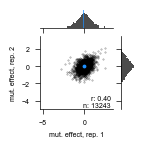

>-400 region


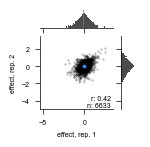

-400 to 168 region


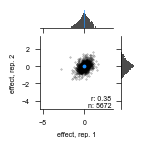

deletions
-400 to 168 region


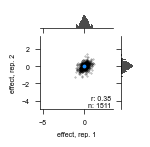

insertions
-400 to 168 region


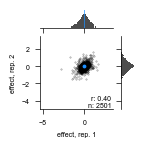

 beta old linreg


/data/davidding/dms/dms_plants/figures/../src/plotting.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1)  # Decrease padding around the entire figure


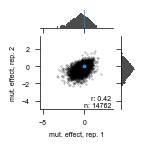

>-400 region


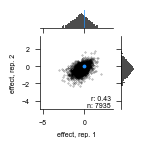

-400 to 70 region


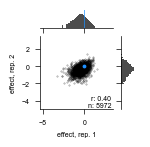

deletions
-400 to 70 region


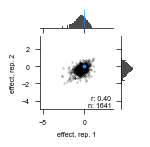

insertions
-400 to 70 region


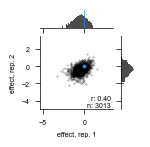

In [9]:

s='2C_sorghum'
start_region = -400
end_region = 168

# for linear regression weights
df_lr1 = pd.read_csv(din_lr + f'{s}_lrr_rep1_lr.csv')
df_lr2 = pd.read_csv(din_lr + f'{s}_lrr_rep2_lr.csv')
df_merge = df_lr1.merge(df_lr2, on = 'mut', suffixes=('_r1','_r2'))
df_merge['pos'] = df_merge.mut.apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)

plot_scatter_rep12_linreg(
        df_merge, start_region, end_region, s, dout,
        align_text_bottom_right=True, xlim = [-5.4, 3.5], ylim = [-5, 3.5])


s='2B_sorghum'
start_region = -400
end_region = 70

# for linear regression weights
df_lr1 = pd.read_csv(din_lr + f'{s}_lrr_rep1_lr.csv')
df_lr2 = pd.read_csv(din_lr + f'{s}_lrr_rep2_lr.csv')
df_merge = df_lr1.merge(df_lr2, on = 'mut', suffixes=('_r1','_r2'))
df_merge['pos'] = df_merge.mut.apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)

plot_scatter_rep12_linreg(
        df_merge, start_region, end_region, s, dout,
        align_text_bottom_right=True, xlim = [-5.4, 3.5], ylim = [-5, 3.5])

# nanoluc panel

In [ ]:
dout = '/data/davidding/dms/plots/fig2/'

df_nl = pd.read_csv('/data/davidding/dms/illumina_data/data/nanoluc/nanoluc_psbs_sorghum.csv')
df_old_linreg = pd.read_csv(f'/data/davidding/dms/illumina_data/linreg_all/3C_sorghum_mean_lrr/_df_coef_0.csv')

# Strip whitespace and lower case for both columns
df_nl['mut'] = df_nl['mut'].str.strip().str.lower()
df_old_linreg['mut'] = df_old_linreg['mut'].str.strip().str.lower()

# Try merging again
df_merge2 = df_nl.merge(df_old_linreg, on='mut')

df_merge2_mean = df_merge2[['mut', 'beta', 'log2(nanoluc_norm)']].groupby('mut').agg('mean')
df_merge2_std = df_merge2[['mut', 'beta', 'log2(nanoluc_norm)']].groupby('mut').agg('std')

df_merge3 = df_merge2_mean.merge(df_merge2_std, on='mut', suffixes=('_mean', '_std'))

# normalize nanoluciferase measurements
df_merge3['log2(nanoluc_norm)_mean'] = df_merge3['log2(nanoluc_norm)_mean'] - np.mean(df_merge3.loc[df_merge3.index =='wt']['log2(nanoluc_norm)_mean'])


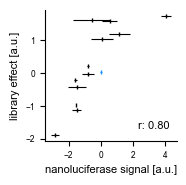

In [ ]:
x=df_merge3.loc[df_merge3.index !='wt']['log2(nanoluc_norm)_mean']
y=df_merge3.loc[df_merge3.index !='wt']['beta_mean']
xerr = df_merge3.loc[df_merge3.index !='wt']['log2(nanoluc_norm)_std']
x1=df_merge3.loc[df_merge3.index =='wt']['log2(nanoluc_norm)_mean']
y1=df_merge3.loc[df_merge3.index =='wt']['beta_mean']
xerr1 = df_merge3.loc[df_merge3.index =='wt']['log2(nanoluc_norm)_std']

fig = plt.figure(figsize= (1.7,1.7))
ax = plt.gca()
plt.errorbar(x, 
             y, 
             xerr=xerr, fmt='|', color='black', linewidth=0.8, markersize=3)
plt.errorbar(x1, 
             y1, 
             xerr=xerr1, fmt='|', color='dodgerblue', linewidth=0.8, markersize=3)

r, _ = pearsonr(df_merge2_mean['beta'], df_merge2_mean['log2(nanoluc_norm)'])
r_text = f"r: {r:.2f}"
# Add textbox in the top left corner of the main scatter plot
ax.text(0.95, 0.15, r_text, transform=ax.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='right')
ax.xaxis.set_tick_params(labelsize=6)
ax.yaxis.set_tick_params(labelsize=6)
plt.xlabel('nanoluciferase signal [a.u.]', fontsize=8)
plt.ylabel('library effect [a.u.]', fontsize=8)
plt.savefig(dout + 'nanoluc_vs_beta.png', dpi=500, bbox_inches="tight")
plt.show()



# volcano plot  


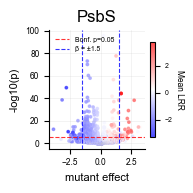

Total number of tests: 19315
Bonferroni threshold: 2.59e-06
Number of significant variants (Bonferroni): 386
Number of variants with |β| > 1.5: 122
Number of variants with |β| > 1.5 AND p < Bonferroni: 52


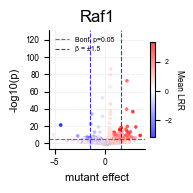

Total number of tests: 14048
Bonferroni threshold: 3.56e-06
Number of significant variants (Bonferroni): 170
Number of variants with |β| > 1.5: 233
Number of variants with |β| > 1.5 AND p < Bonferroni: 62


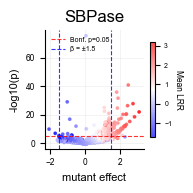

Total number of tests: 13976
Bonferroni threshold: 3.58e-06
Number of significant variants (Bonferroni): 176
Number of variants with |β| > 1.5: 90
Number of variants with |β| > 1.5 AND p < Bonferroni: 79


(<Figure size 200x200 with 2 Axes>,
 <Axes: title={'center': 'SBPase'}, xlabel='mutant effect', ylabel='-log10(p)'>)

In [ ]:
def create_volcano_plot(df_lr, title='', dout=''):
    """
    Create a volcano plot with beta vs -log10(pval), colored by mean_lrr_observed_reads
    with Bonferroni correction and beta=1.5 threshold lines.
    """
    # Create volcano plot
    fig, ax = plt.subplots(figsize=(2,2))
    
    # Calculate -log10(p-value)
    df_lr['neg_log10_pval'] = -np.log10(df_lr['pval'])
    
    # Create scatter plot colored by mean_lrr_observed_reads using bwr colormap
    scatter = ax.scatter(df_lr['beta'], df_lr['neg_log10_pval'], 
                        c=df_lr['mean_lrr_observed_reads'], 
                        alpha=0.7, s=3, cmap='bwr')
    
    # Add colorbar with smaller font
    cbar = plt.colorbar(scatter, shrink=0.8)
    cbar.set_label('Mean LRR', rotation=270, labelpad=8, fontsize=6)
    cbar.ax.tick_params(labelsize=5)
    
    # Calculate Bonferroni correction threshold
    n_tests = len(df_lr)
    bonferroni_threshold = 0.05 / n_tests
    bonferroni_log10 = -np.log10(bonferroni_threshold)
    
    # Add horizontal line for Bonferroni p-value cutoff
    ax.axhline(y=bonferroni_log10, color='red', linestyle='--', alpha=0.8, linewidth=0.8,
               label=f'Bonf. p=0.05')
    
    # Add vertical lines for beta = ±1.5
    ax.axvline(x=1.5, color='blue', linestyle='--', alpha=0.8, linewidth=0.8, label='β = ±1.5')
    ax.axvline(x=-1.5, color='blue', linestyle='--', alpha=0.8, linewidth=0.8)
    
    # Set labels and title with smaller fonts
    ax.set_xlabel('mutant effect', fontsize=8)
    ax.set_ylabel('-log10(p)', fontsize=8)
    ax.set_title('Volcano Plot', fontsize=9, fontweight='bold')
    
    # Smaller tick labels
    ax.tick_params(axis='both', which='major', labelsize=6)
    
    # Add legend with smaller font
    ax.legend(loc='upper left', fontsize=5, frameon=False)
    
    # Light grid for better readability
    ax.grid(True, alpha=0.2, linewidth=0.5)
    
    # Adjust layout
    plt.tight_layout()
    
    if title != '':
        plt.title(title)
    if dout != '':
        plt.savefig(dout + title + '_volcano_plot.png', dpi=500, bbox_inches="tight")
    # Show plot
    plt.show()
    
    # Print some statistics
    print(f"Total number of tests: {n_tests}")
    print(f"Bonferroni threshold: {bonferroni_threshold:.2e}")
    print(f"Number of significant variants (Bonferroni): {sum(df_lr['pval'] < bonferroni_threshold)}")
    print(f"Number of variants with |β| > 1.5: {sum(abs(df_lr['beta']) > 1.5)}")
    print(f"Number of variants with |β| > 1.5 AND p < Bonferroni: {sum((abs(df_lr['beta']) > 1.5) & (df_lr['pval'] < bonferroni_threshold))}")
    
    return fig, ax

s = '3C_sorghum'
df_lr = pd.read_csv(din_lr + s + '_mean_lrr_lr.csv')

create_volcano_plot(df_lr, title = 'PsbS', dout = dout)

s = '3B_sorghum'
df_lr = pd.read_csv(din_lr + s + '_mean_lrr_lr.csv')

create_volcano_plot(df_lr, title = 'Raf1', dout = dout)

s = '3A_sorghum'
df_lr = pd.read_csv(din_lr + s + '_mean_lrr_lr.csv')

create_volcano_plot(df_lr, title = 'SBPase', dout = dout)
